## 1.Import 

In [8]:
import os
import pandas as pd
import gc
import sys
from pathlib import Path
import requests
import re
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import Image
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches





import warnings
warnings.filterwarnings("ignore")


# Get the absolute path to the 'utils' directory, which is assumed to be
# in the parent directory of the current Jupyter notebook's location.
utils_dir = str(Path.cwd().parent / "utils")

# Add the 'utils' directory to sys.path if it's not already included.
if utils_dir not in sys.path:
    sys.path.append(utils_dir)

# Import all functions from the '../utils/utils_v2.py' and  directory.
from utils_v2 import *

## 2. Read the data

In [9]:
os.listdir('../../Scraping_fbref_static_data/data/old_seasons')

['.DS_Store',
 'top5_leagues_keeper_2018_2019__2022_2023.csv',
 'top5_leagues_team_2018_2019__2022_2023.csv',
 'top5_leagues_team_vs_2018_2019__2022_2023.csv',
 'top5_leagues_outfields_2018_2019__2022_2023.csv']

In [10]:
os.listdir('../../Scraping_fbref_static_data/data/current_season')

['.DS_Store', '2024-03-08', '2024-03-06', '2024-03-12', '2024-03-02']

In [11]:
date = '2024-03-12'

os.listdir(f'../../Scraping_fbref_static_data/data/current_season/{date}')

['top5_leagues_team_vs_2023_2024.csv', 'top5_leagues_team_2023_2024.csv']

In [12]:
path1 = '../../Scraping_fbref_static_data/data/old_seasons'
path2 = '../../Scraping_fbref_static_data/data/current_season'

In [14]:
#TOP5 europen leagues last 5 seasons
# df_players_old = pd.read_csv('/'.join((path1, 'top5_leagues_outfields_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
# df_keeper_old = pd.read_csv('/'.join((path1, 'top5_leagues_keeper_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
df_team_old = pd.read_csv('/'.join((path1, 'top5_leagues_team_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)
df_team_vs_old = pd.read_csv('/'.join((path1, 'top5_leagues_team_vs_2018_2019__2022_2023.csv')), index_col=0).reset_index(drop=True)

#TOP5 europen leagues current seasons (up-to-{date})
# df_players = pd.read_csv('/'.join((path2, date, 'top5_leagues_outfields_2023_2024.csv')), index_col=0).reset_index(drop=True)
# df_keeper = pd.read_csv('/'.join((path2, date, 'top5_leagues_keeper_2023_2024.csv')), index_col=0).reset_index(drop=True)
df_team = pd.read_csv('/'.join((path2, date, 'top5_leagues_team_2023_2024.csv')), index_col=0).reset_index(drop=True)
df_team_vs = pd.read_csv('/'.join((path2, date, 'top5_leagues_team_vs_2023_2024.csv')), index_col=0).reset_index(drop=True)


## 3. Calculate statistics

- calculate attack statistics + DA

In [15]:
# Function to perform the calculations on a dataframe
def process_team_dataframe(df):
    df['gk_passes_length_avg_m'] = round(df['gk_passes_length_avg'] * 0.9144,2)
    df['Shots on target%'] = round(df['shots_on_target_per90'] / df['shots_per90'] * 100,2)
    df['Passes to final 3rd%'] = round(df['passes_into_final_third'] / df['passes_completed'] * 100,2)
    df['Passes to PA'] = round(df['passes_into_penalty_area'] / df['games'],2)
    df['box crosses%'] = round(df['crosses_into_penalty_area'] /  df['passes_into_penalty_area'] *100,2)
    df['Carries to final 3rd%'] = round(df['carries_into_final_third'] / df['carries']*100,2)
    df['Carries to PA'] = round(df['carries_into_penalty_area'] / df['games'],2)
    df['Touches final 3rd%'] = round(df['touches_att_3rd'] / df['touches_live_ball']*100,2)
    df['npxg/Shot on target'] = round(df['npxg_per90'] / df['shots_on_target_per90'],2)
    df['xa_per90'] = round(df['pass_xa'] / df['games'],2)
    df['touches in PA'] = round(df['touches_att_pen_area'] / df['games'],2)
    #just for df with direct statistic
    if df['squad'][0].split(' ')[0] != 'vs':
        df['DA'] = df['tackles'] + df['challenge_tackles'] + df['interceptions'] + df['fouls']
#         df['gk_psxg_per90'] = round(df['gk_psxg'] / df['games'],2)

    return df

In [16]:
# Applying adjustments and processing
df_team = process_team_dataframe(df_team)
df_team_old = process_team_dataframe(df_team_old)

df_team_vs = process_team_dataframe(df_team_vs)
df_team_vs_old = process_team_dataframe(df_team_vs_old)

- calculate defensive statistics
    - <b>PPDA</b>

In [17]:
def calculate_PPDA(df_vs, df):
    
    df_vs_ = df_vs.copy()
    df_ = df.copy()
    
    df_vs_['squad'] = df_vs_['squad'].apply(lambda x: x.replace('vs ',''))
    df_['squad'] = df_['squad'].apply(lambda x: x.replace('vs ',''))

    
    cols_to_merge = ['squad','season','DA']
    
    if 'PPDA' not in df_vs_.columns:

        df_merged = pd.merge(df_vs_, df_[cols_to_merge], on=['squad','season'])

        df_merged['PPDA'] = round(df_merged['passes'] / df_merged['DA'],2)

        del df_, df_vs_
        df_, df_vs = pd.DataFrame(), pd.DataFrame()
        gc.collect()

        return df_merged

    else:
        return df_vs



In [18]:
df_team_vs = calculate_PPDA(df_team_vs, df_team)
df_team_vs_old = calculate_PPDA(df_team_vs_old, df_team_old)

- add gk_psxg_net_per90 to dfs with against statistic 

In [19]:
df_team_vs['gk_psxg_net_per90'] = df_team['gk_psxg_net_per90']
df_team = df_team.drop(['gk_psxg_net_per90'], axis=1)

df_team_vs_old['gk_psxg_net_per90'] = df_team_old['gk_psxg_net_per90']
df_team_old = df_team_old.drop(['gk_psxg_net_per90'], axis=1)

- calculate defensive statistics
    - <b>tackles_interceptions_adj_per90</b>

In [20]:
# Function to adjust tackles and interceptions
def adjust_tackles_interceptions(df):
    df['minutes_wo_ball'] = (100 - df['possession']) / 100 * df['games'] * 90
    df['minutes_exp'] = df['games'] * 90 / 2
    df['tackles_interceptions_adj'] = df['tackles_interceptions'] / df['minutes_wo_ball'] * df['minutes_exp']
    df['tackles_interceptions_adj_per90'] = round(df['tackles_interceptions_adj'] / df['games'], 2)
    return df

# # Adjusting tackles and interceptions for both current and old team data
df_team = adjust_tackles_interceptions(df_team)
df_team_old = adjust_tackles_interceptions(df_team_old)

cols = ['tackles_interceptions_adj_per90', 'squad', 'season']
df_team_vs = pd.merge(df_team_vs, df_team[cols], on =['squad','season'])
df_team_vs_old = pd.merge(df_team_vs_old, df_team_old[cols], on =['squad','season'])




## 4. Create a Colors Dictionary for Teams

- Assign default colors to the teams: one team with #004D98 and the other with #DB0030

In [21]:
color_dict = {'Manchester City':'#004D98',
              'Manchester Utd':'#DB0030',
              'Arsenal':'#DB0030',
              'Chelsea':'#004D98',
              'Liverpool':'#DB0030',
              'Atletico': '#DB0030',
              'Barcelona':'#004D98',
              'Real Madrid':'#004D98',
              'Atlético Madrid':'#004D98'}

## 5. Chose metrics for Radar

1. metrics_dict_{attack/def}: 

- A dictionary that maps column names to their corresponding abbreviations for display on an Attacking or Defending Radar chart. 
- The 'type' key in the dictionary specifies the direction of the range on the radar for each specific metric.


2. metrics_to_plot_{attack/def}: 

- A set containing the names of metrics that will be visualized on either an Attacking or Defending Radar chart.

In [22]:
metrics_dict_attack = {'xG'                    : {'m':'xg_per90', 'type':1},
                       'npxG'                  : {'m':'npxg_per90', 'type':1},
                       'Shots'                 : {'m':'shots_per90', 'type':1},
                       'npxG/Shot'             : {'m':'npxg_per_shot','type':1},
                       'G/Shot'                : {'m':'goals_per_shot','type':1},
                       'Shots on target%'      : {'m':'Shots on target%','type':1},
                       'Shots on target'       : {'m':'shots_on_target_per90','type':1},
                       'G/Shot on target'      : {'m':'goals_per_shot_on_target','type':1},
                       'Passes to final 3rd%'  : {'m':'Passes to final 3rd%','type':1},
                       'Passes to PA'          : {'m':'Passes to PA','type':1},
                       'box crosses%'          : {'m':'box crosses%','type':0},
                       'Carries to final 3rd%' : {'m':'Carries to final 3rd%','type':1},
                       'Carries to PA'         : {'m':'Carries to PA','type':1},
                       'Touches final 3rd%'    : {'m':'Touches final 3rd%','type':1},
                       'Gk passes length'      : {'m':'gk_passes_length_avg_m','type':0},
                       'npxg/Shot on target'   : {'m':'npxg/Shot on target','type':1},
                       'GCA'                   : {'m':'gca_per90','type':1},
                       'xA'                    : {'m':'xa_per90','type':1},
                       'touches in PA'         : {'m':'touches in PA','type':1}
                  }

metrics_to_plot_attack = ['npxG', 
                          'npxG/Shot',
                          'Shots',
                          'Shots on target', 
#                           'GCA', 
                          'xA', \
                          'Passes to PA', 
                          'Carries to PA', 
                          'touches in PA', 
                          'Gk passes length',
                          'box crosses%'
                  ]

metrics_dict_def =    {'xG C.'                    : {'m':'xg_per90', 'type':0},
                       'npxG C.'                  : {'m':'npxg_per90', 'type':0},
                       'Shots C.'                 : {'m':'shots_per90', 'type':0},
                       'npxG/Shot C.'             : {'m':'npxg_per_shot','type':0},
                       'G/Shot C.'                : {'m':'goals_per_shot','type':0},
                       'Shots on target% C.'      : {'m':'Shots on target%','type':0},
                       'Shots on target C.'       : {'m':'shots_on_target_per90','type':0},
                       'G/Shot on target C.'      : {'m':'goals_per_shot_on_target','type':0},
#                        'Passes to final 3rd%'  : {'m':'Passes to final 3rd%','type':1},
                       'Passes to PA C.'          : {'m':'Passes to PA','type':0},
#                        'box crosses%'          : {'m':'box crosses%','type':0},
#                        'Carries to final 3rd%' : {'m':'Carries to final 3rd%','type':1},
                       'Carries to PA C.'         : {'m':'Carries to PA','type':0},
#                        'Touches final 3rd%'    : {'m':'Touches final 3rd%','type':1},
#                        'Gk passes length'      : {'m':'gk_passes_length_avg_m','type':0},
                       'npxg/Shot on target C.'   : {'m':'npxg/Shot on target','type':0},
                       'GCA C.'                   : {'m':'gca_per90','type':0},
                       'xA C.'                    : {'m':'xa_per90','type':0},
                       'touches in PA C.'         : {'m':'touches in PA','type':0},
                       'PPDA'                           : {'m':'PPDA','type':0},
                       'Tackl. & Interc (adj)'         : {'m':'tackles_interceptions_adj_per90','type':1},
                       'PSxG-GA'                     : {'m':'gk_psxg_net_per90','type':1},

                  }
metrics_to_plot_def = [ 
                       'npxG C.',
                       'npxG/Shot C.',
                       'Shots C.',
                       'Shots on target C.', 
                       'xA C.', 
#                        'Passes to PA C.', 
#                        'Carries to PA C.', 
                       'touches in PA C.',
                       'PPDA',
                        'Tackl. & Interc (adj)',
                           'PSxG-GA'

]



In [23]:
dict_m = {'Attacking Radar':{'metric_dict':metrics_dict_attack,
                             'metric_to_plot':metrics_to_plot_attack},
         'Defending Radar':{'metric_dict':metrics_dict_def,
                             'metric_to_plot':metrics_to_plot_def}}

## 6. Create Radar (step-by-step guide)

### 6.1 Create folders for saving images

In [25]:
# date = str(pd.to_datetime(datetime.now()).date())

date = '2024-03-12'


if date not in os.listdir('../img'):
    os.mkdir(f'../img/{date}')
for type_ in ['stats_image','radar_image','distri_image']:
    if type_ not in os.listdir(f'../img/{date}'):
        os.mkdir(f'../img/{date}/{type_}')

### 6.2 Choose teams, radar type, metric_dict, metric_to_plot

In [27]:
team1 = 'Barcelona'
team2 = 'Napoli'

rt = 'Attacking Radar'

metric_dict = dict_m[rt]['metric_dict']
metric_to_plot = dict_m[rt]['metric_to_plot']

### 6.3 Get DF with metrics

In [28]:
df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
df_metrics

,Statistic_Barcelona,Statistic_Napoli,p5,p95,Barcelona_p,Napoli_p
games,28.00,28.00,NaN,NaN,NaN,NaN
npxG,2.04,1.40,0.8445,1.8200,98.0,77.0
npxG/Shot,0.13,0.09,0.0800,0.1300,98.0,36.0
Shots,15.79,16.71,9.4200,16.2985,92.0,96.0
Shots on target,5.82,5.21,2.8990,5.8400,95.0,87.0
xA,1.64,1.03,0.5800,1.4555,97.0,74.0
Passes to PA,11.25,10.61,4.8900,11.6600,94.0,91.0
Carries to PA,6.68,5.18,2.3290,6.7265,94.0,77.0
touches in PA,28.68,27.64,14.3320,29.6680,93.0,91.0
Gk passes length,23.32,26.97,42.8900,22.4360,92.0,78.0


### 6.3 Transform DF for use in visualization

In [29]:
df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
df_metrics_v2

index_name,Barcelona,1,Napoli,2
90s played,28,,28,
competition,La-Liga,,Serie-A,
season,2023-2024,,2023-2024,
,value,perc,value,perc
npxG,2.04,98.0,1.4,77.0
npxG/Shot,0.13,98.0,0.09,36.0
Shots,15.79,92.0,16.71,96.0
Shots on target,5.82,95.0,5.21,87.0
xA,1.64,97.0,1.03,74.0
Passes to PA,11.25,94.0,10.61,91.0


### 6.4 Work with style

In [30]:
image = metrics_to_image(df_metrics_v2, color_dict, rt, date)

In [31]:
os.listdir(f'../img/{date}/stats_image')

['Stats_Attacking_Radar_Barcelona_Napoli_2024-03-12_2023-2024.jpeg']

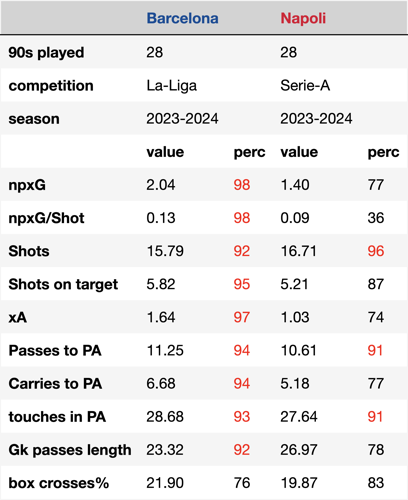

In [34]:
file = 'Stats_Attacking_Radar_Barcelona_Napoli_2024-03-12_2023-2024.jpeg'
image_ = Image.open(f'../img/{date}/stats_image/{file}', )
size = (500, 500)
image_.thumbnail(size)
image_

### 6.5 Plotting Radar and Statistics

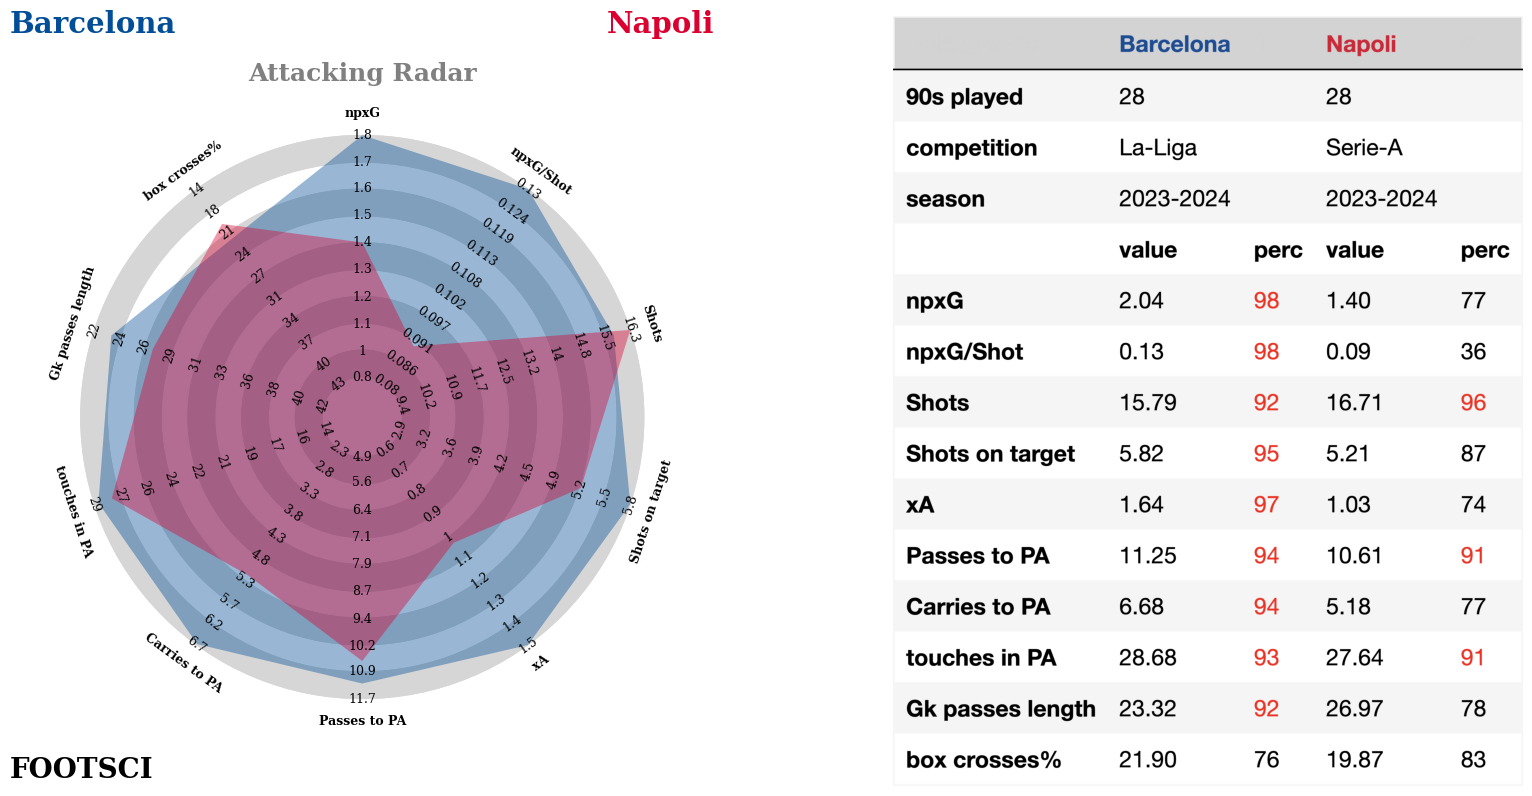

In [36]:
plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image)


## 7. Encapsulate all actions in a loop

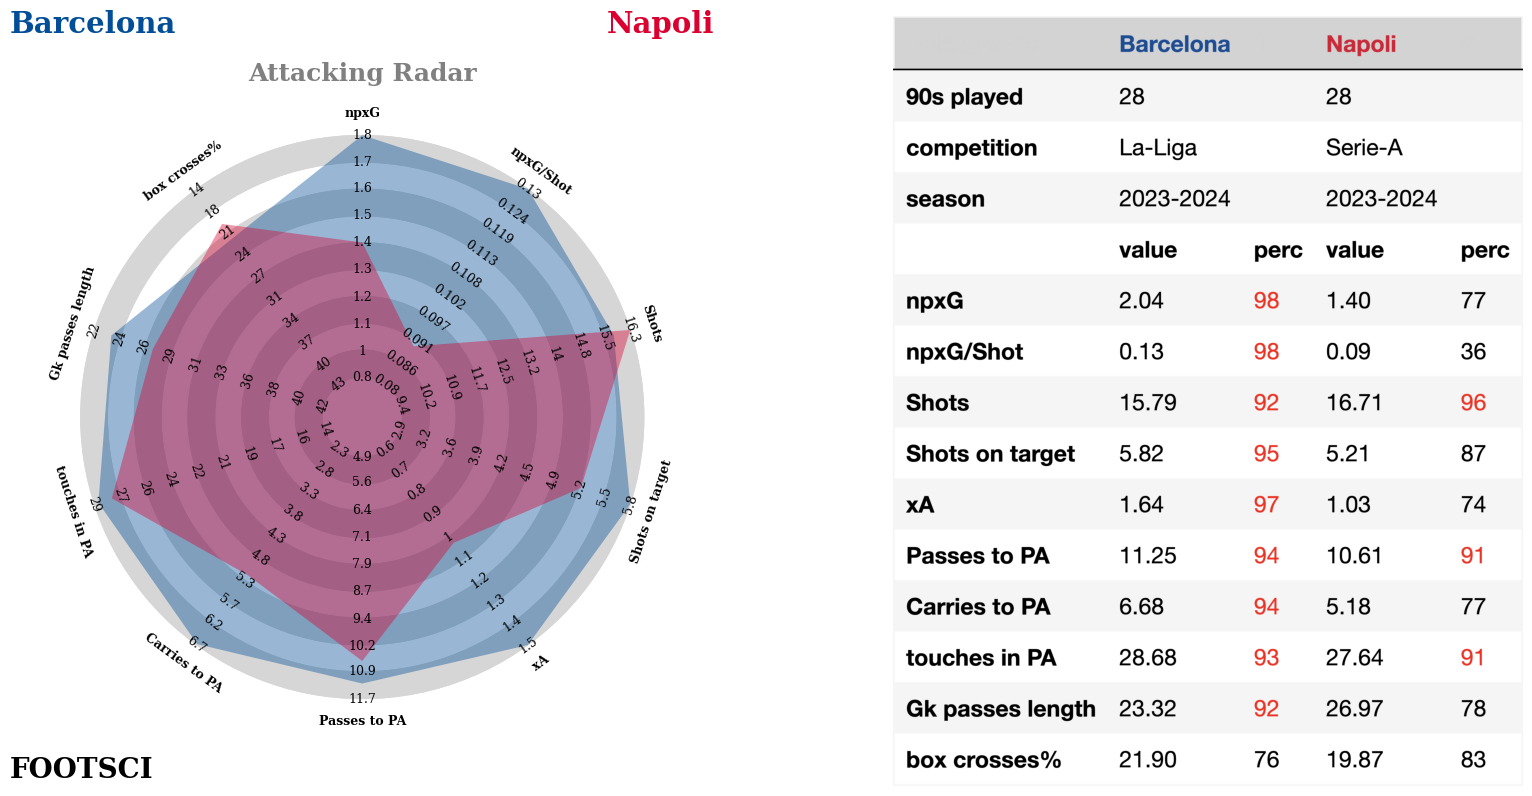

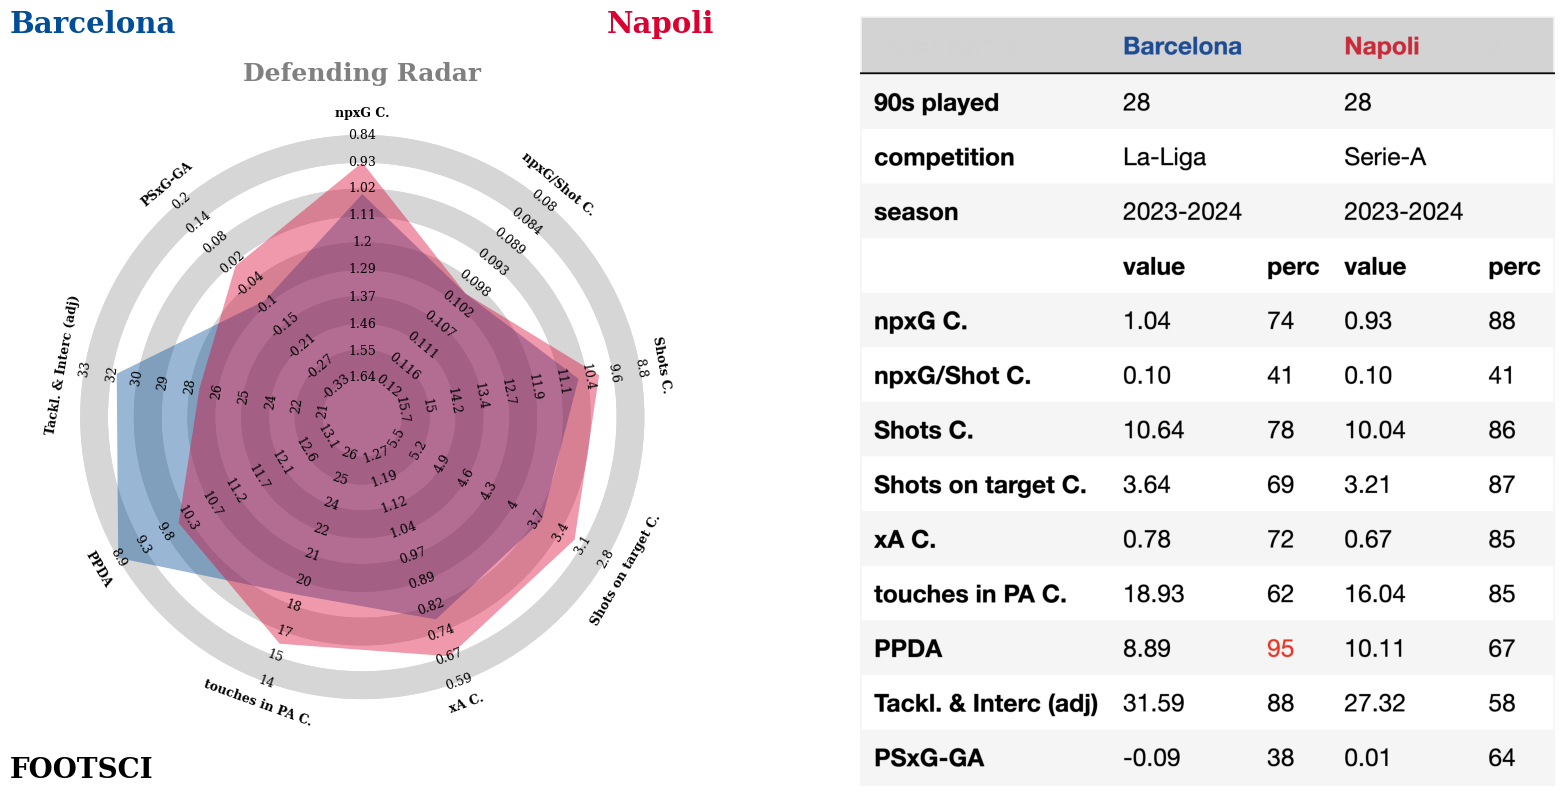

In [37]:
team1 = 'Barcelona'
team2 = 'Napoli'

radar_order = []

for rt in ['Attacking Radar', 'Defending Radar']:

    metric_dict = dict_m[rt]['metric_dict']
    metric_to_plot = dict_m[rt]['metric_to_plot']

    if rt == 'Attacking Radar':

        df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
        df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
        image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
        plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image)
        team1 = df_metrics_v2.columns[0]
        team2 = df_metrics_v2.columns[2]
        radar_order.append(team1)
        radar_order.append(team2)
    else:
        df_metrics = get_df_metrics(df_team_vs, df_team_vs_old, team1, team2, metric_dict, metric_to_plot)
        df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt, radar_order = radar_order)
        image = metrics_to_image(df_metrics_v2, color_dict, rt, date)
        plot_radar(df_metrics, df_metrics_v2, rt, color_dict, date, image, radar_order = radar_order)
#     break


## 7. Get distibutions

- first steps the same 

In [38]:
team1 = 'Barcelona'
team2 = 'Napoli'

rt = 'Attacking Radar'

metric_dict = dict_m[rt]['metric_dict']
metric_to_plot = dict_m[rt]['metric_to_plot']


df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)

- use function get_dist

In [39]:
image = get_dist(df_team_old, df_team, df_metrics_v2, team1, metrics_dict_attack, 'Attacking Radar',date)

In [40]:
os.listdir(f'../img/{date}/distri_image')

['Distri_Attacking_Radar_Barcelona_2024-03-12_2023-2024.jpeg']

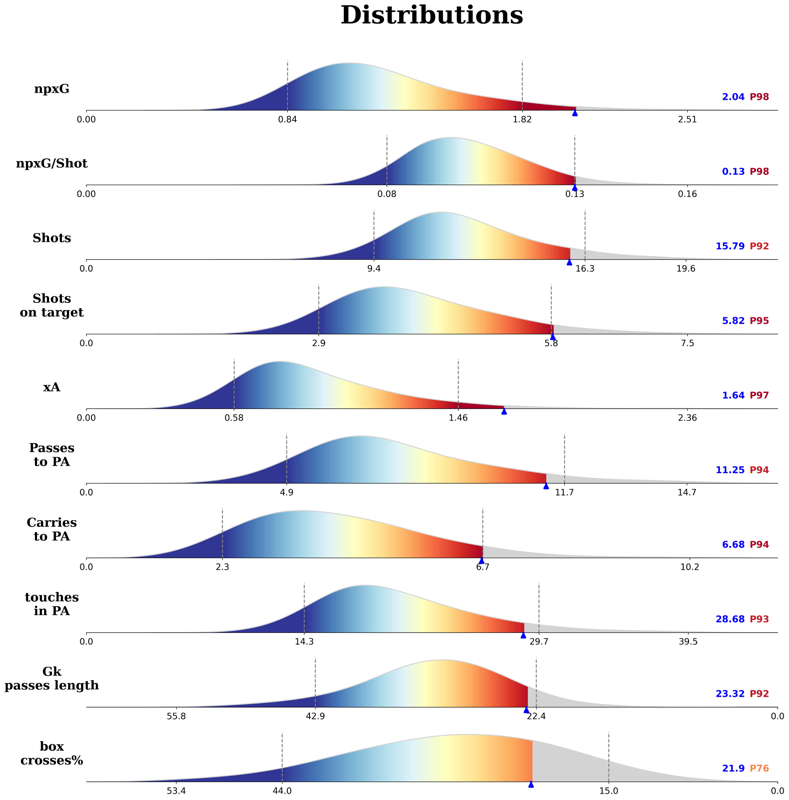

In [42]:
file = 'Distri_Attacking_Radar_Barcelona_2024-03-12_2023-2024.jpeg'
image_ = Image.open(f'../img/{date}/distri_image/{file}', )
size = (1500, 800)
image_.thumbnail(size)
image_

## 8. Create a Colors Dictionary for Teams (v2)

In [43]:
team_color_pairs = {
    'Manchester City': ['#6CABDD', '#FFFFFF'],  # Sky blue and white
    'Manchester Utd': ['#DA291C', '#FFE500'],  # Red and yellow/gold
    'Arsenal': ['#EF0107', '#FFFFFF'],  # Red and white
    'Chelsea': ['#034694', '#FFFFFF'],  # Royal blue and white
    'Liverpool': ['#C8102E', '#00B2A9'],  # Red and teal
    'Atletico': ['#CB3524', '#FFFFFF'],  # Red and white (assuming Atletico Madrid)
    'Barcelona': ['#A50044', '#004D98'],  # Deep red and blue
    'Real Madrid': ['#FEBE10', '#FFFFFF'],  # Yellow and white
    'Atlético Madrid': ['#272E61', '#CB3524'],  # Blue and red
    'Paris S-G': ['#004170', '#DA291C'],  # Blue and red
    'Napoli': ['#12A0D7', '#FFFFFF']
}


## 9. Plotting Radar and Distributions

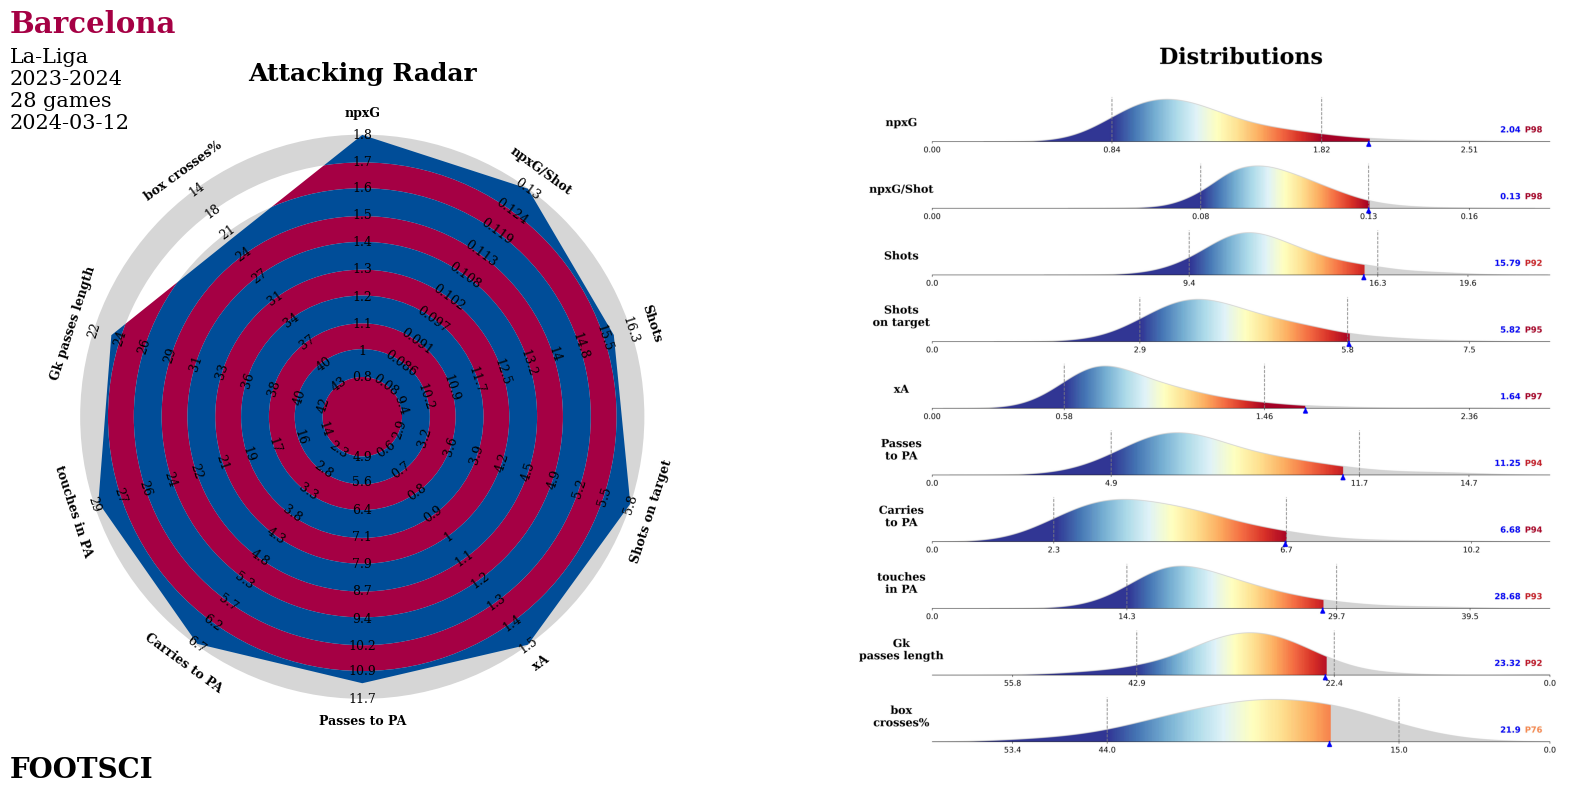

In [44]:
plot_radar(df_metrics, df_metrics_v2, rt, team_color_pairs, date, image, team_name=team1)

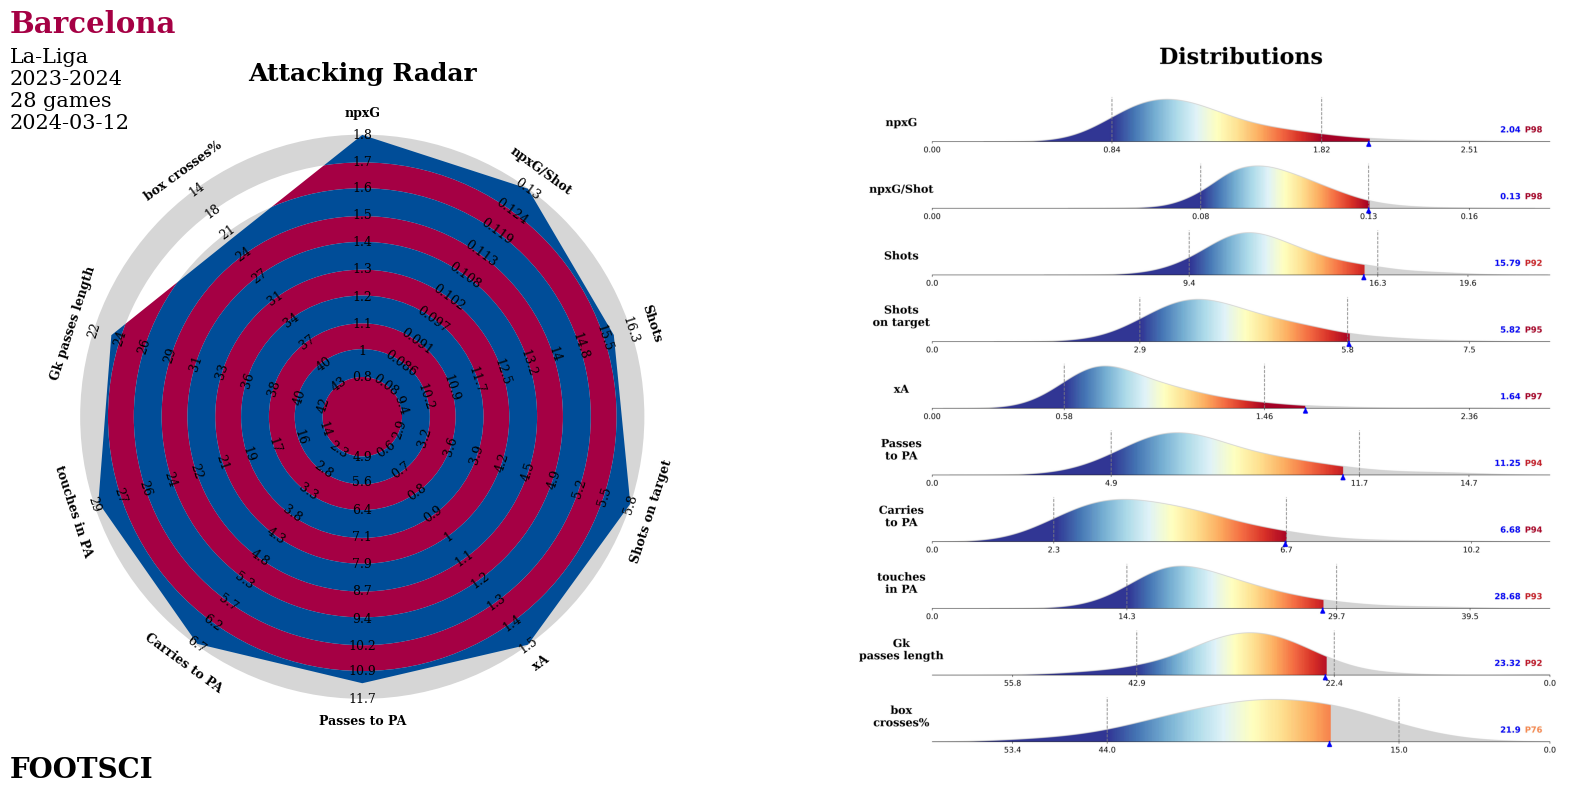

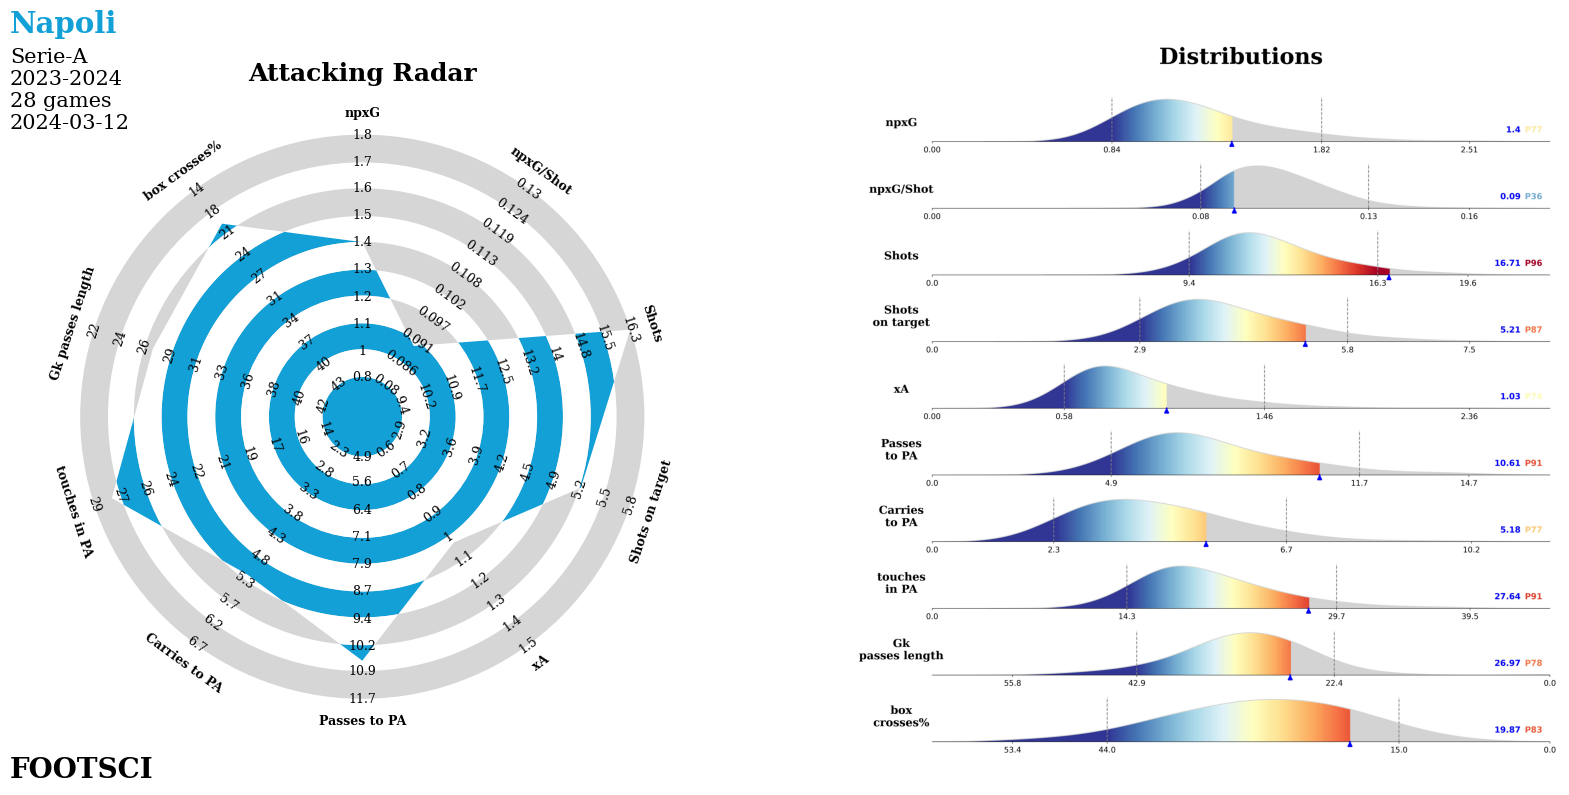

neg


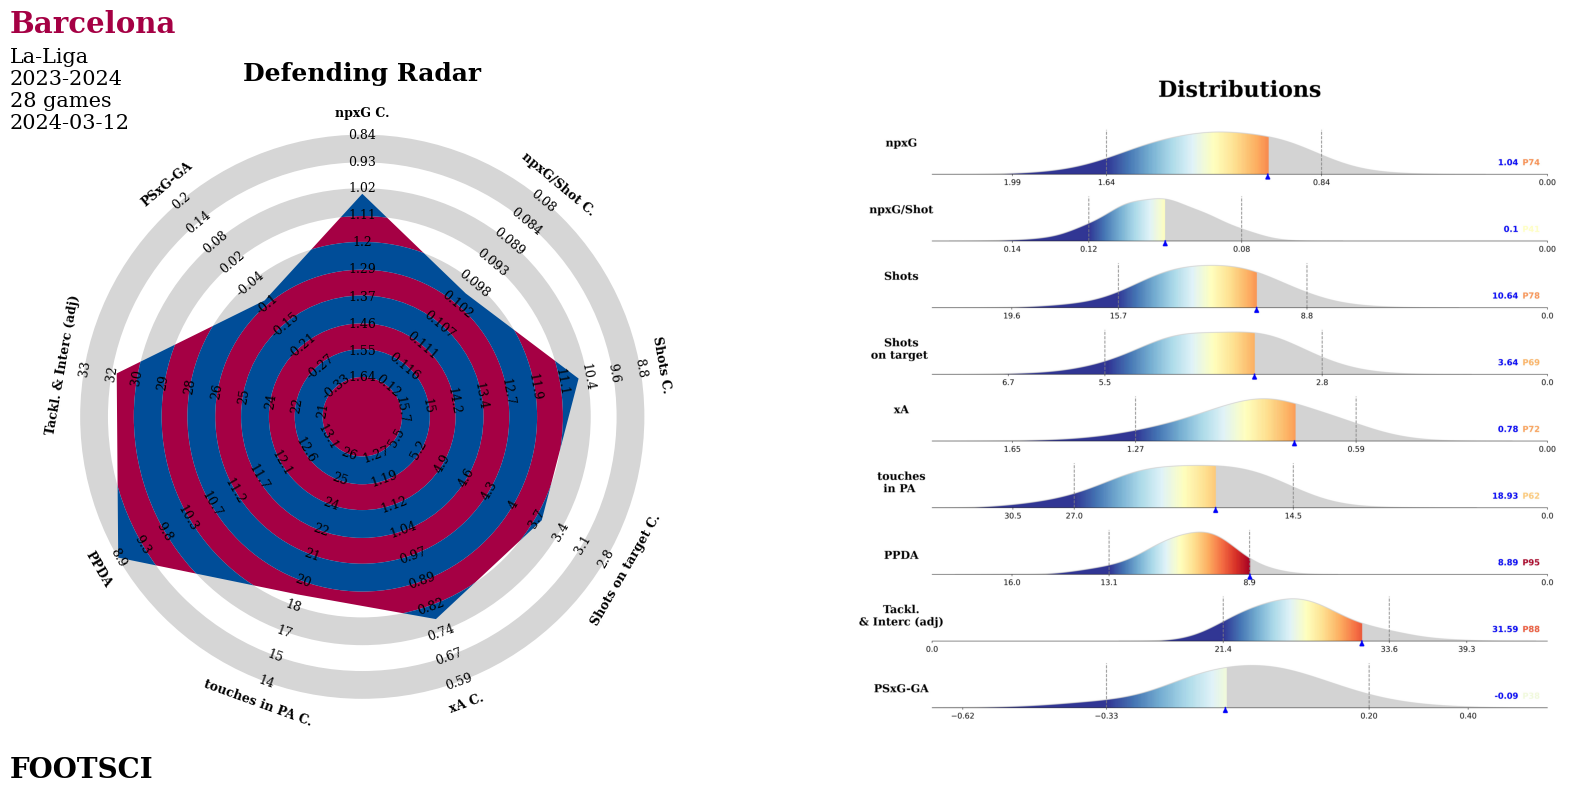

neg


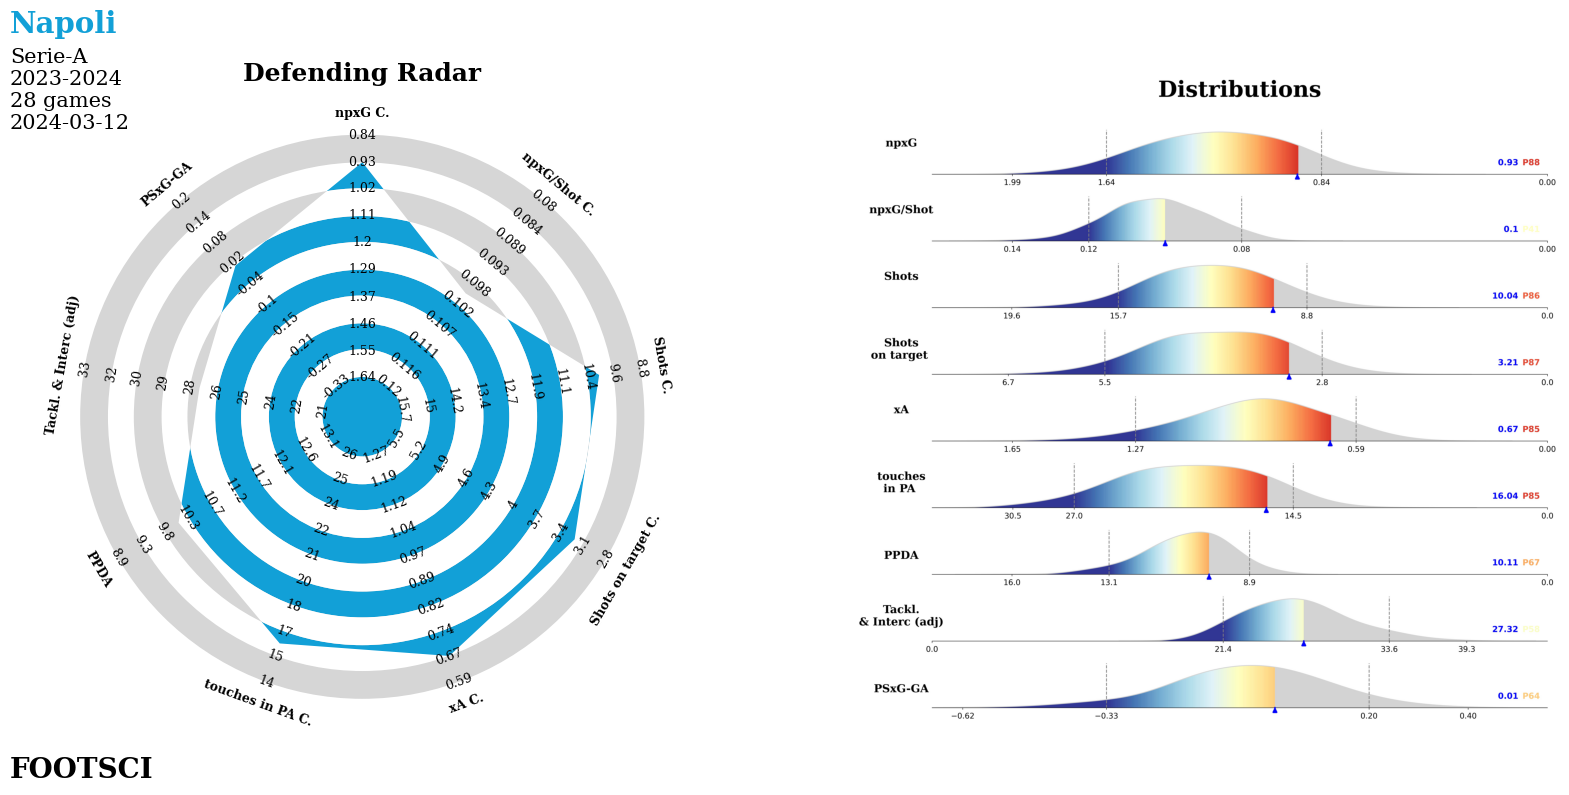

In [45]:
team1 = 'Barcelona'
team2 = 'Napoli'
# team_ = team1

radar_order = []

for rt in ['Attacking Radar', 'Defending Radar']:
    
    for team_ in [team1, team2]:

        metric_dict = dict_m[rt]['metric_dict']
        metric_to_plot = dict_m[rt]['metric_to_plot']

        if rt == 'Attacking Radar':

            df_metrics = get_df_metrics(df_team, df_team_old, team1, team2, metric_dict, metric_to_plot)
            df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt)
            image = get_dist(df_team_old, df_team, df_metrics_v2, team_, metrics_dict_attack, 'Attacking Radar',date)
            plot_radar(df_metrics, df_metrics_v2, rt, team_color_pairs, date, image, team_name=team_)
            team1 = df_metrics_v2.columns[0]
            team2 = df_metrics_v2.columns[2]
            radar_order.append(team1)
            radar_order.append(team2)
        else:
            df_metrics = get_df_metrics(df_team_vs, df_team_vs_old, team1, team2, metric_dict, metric_to_plot)
            df_metrics_v2 = preprocessing_df_metric(df_metrics, df_team, rt, radar_order = radar_order)
            image = get_dist(df_team_vs_old, df_team_vs, df_metrics_v2, team_, metrics_dict_def, 'Defending Radar',date)
            plot_radar(df_metrics, df_metrics_v2, rt, team_color_pairs, date, image, team_name=team_)
